importamos las bibliotecas

In [145]:
import torch
import torch.nn as nn
import torch.nn.functional as F


creamos una clase modelo que herede el nn.modulo

In [146]:
class Model(nn.Module):
    # capa de entrada que tiene 23 caracteristicas --> 
    # capa oculta1 con n neuronas  --> 
    # capa oculta2 con n neuronas --> 
    # capa de salida con 1 neurona y 3 clases de respuesta
    def __init__(self, in_entradas=3, h1=30, h2=16, out_salidas=3):
        super(Model, self).__init__()
        # Definimos las capas lineales
        self.fc1 = nn.Linear(in_entradas, h1)  # Capa de entrada a capa oculta 1
        self.fc2 = nn.Linear(h1, h2)            # Capa oculta 1 a capa oculta 2
        self.out = nn.Linear(h2, out_salidas)   # Capa oculta 2 a capa de salida

    def adelante(self, x):
        # función de activación ReLU para las capas ocultas
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        # función de activación softmax para la capa de salida
        x = self.out(x)

        return x
    

elegimos una semilla manualmente para poder elegir un numero aleatoriamente e instanciamos el modelo 

In [147]:
torch.manual_seed(5)  # Elegimos una semilla manualmente para poder elegir un numero aleatoriamente

model = Model()

importamos matplotlib

In [148]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

importamos el dataset 

In [149]:
my_data = pd.read_csv('16_air_quality_prediction.csv', sep=',')


In [150]:
#revisamos los datos
my_data

,date,location,pm2.5,pm10,temperature,predicted_aqi
0,2023-01-01,Istanbul,29.05,58.73,15.4,40.71
1,2023-01-01,Ankara,24.74,83.86,26.4,50.63
2,2023-01-01,Izmir,23.90,76.91,27.8,39.67
3,2023-01-01,Bursa,43.67,49.58,30.6,36.50
4,2023-01-02,Istanbul,28.40,76.31,23.9,46.89
...,...,...,...,...,...,...
1455,2023-12-30,Bursa,32.45,92.85,19.0,54.18
1456,2023-12-31,Istanbul,35.23,63.02,23.2,46.39
1457,2023-12-31,Ankara,45.30,47.77,8.4,44.05
1458,2023-12-31,Izmir,37.29,64.74,30.9,52.19


In [151]:
import numpy as np

condiciones = [
    my_data['predicted_aqi'] < 30,
    (my_data['predicted_aqi'] >= 30) & (my_data['predicted_aqi'] < 40),
    my_data['predicted_aqi'] >= 40
]
valores = [0, 1, 2]

my_data['predicted_aqi'] = np.select(condiciones, valores)

In [152]:
my_data #revisamos los datos nuevamente

,date,location,pm2.5,pm10,temperature,predicted_aqi
0,2023-01-01,Istanbul,29.05,58.73,15.4,2
1,2023-01-01,Ankara,24.74,83.86,26.4,2
2,2023-01-01,Izmir,23.90,76.91,27.8,1
3,2023-01-01,Bursa,43.67,49.58,30.6,1
4,2023-01-02,Istanbul,28.40,76.31,23.9,2
...,...,...,...,...,...,...
1455,2023-12-30,Bursa,32.45,92.85,19.0,2
1456,2023-12-31,Istanbul,35.23,63.02,23.2,2
1457,2023-12-31,Ankara,45.30,47.77,8.4,2
1458,2023-12-31,Izmir,37.29,64.74,30.9,2


In [153]:
X = my_data[my_data['location'] == 'Istanbul'].drop('date', axis=1)
y = X['predicted_aqi']
X = X.drop(['predicted_aqi'], axis=1)
X = X.drop(['location'], axis=1)


In [154]:
#revisamos las y
y



0       2
4       2
8       2
12      2
16      2
       ..
1440    1
1444    2
1448    1
1452    2
1456    2
Name: predicted_aqi, Length: 365, dtype: int64

In [155]:
#revisamos X
X

,pm2.5,pm10,temperature
0,29.05,58.73,15.4
4,28.40,76.31,23.9
8,43.43,53.22,19.1
12,54.22,73.83,15.6
16,41.57,63.21,11.8
...,...,...,...
1440,34.31,61.09,7.9
1444,48.05,72.21,13.4
1448,33.08,70.98,24.0
1452,39.52,66.59,10.8


convertimos a arreglos de numpy 

In [156]:
X = X.values
y = y.values



In [157]:
from sklearn.model_selection import train_test_split

In [158]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.08, random_state=5)

In [159]:
#convertimos a tensores de pytorch
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)

In [160]:
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

In [161]:
#fijar el criterio de perdida y cuan lejos estamos de la respuesta correcta

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)


haremos el entrenamiento del modelo

In [162]:
#entrenamos el modelo 
epochs = 10000
losses = []
for i in range(epochs):
    # pasamos los datos por el modelo
    y_pred = model.adelante(X_train)

    # Computamos y mostramos la pérdida
    loss = criterion(y_pred, y_train)
    losses.append(loss.detach().numpy())
    
    if (i+1) % 10 == 0:
        print(f'Epoch {i+1}/{epochs}, Loss: {loss}')
    # Hacemos el backward pass y optimizamos
    optimizer.zero_grad()  # Zero gradients, else they will accumulate between epochs
    loss.backward()        # Backpropagation, compute gradients
    optimizer.step()       # actualizamos los pesos

Epoch 10/10000, Loss: 0.929318368434906
Epoch 20/10000, Loss: 0.872479259967804
Epoch 30/10000, Loss: 0.8157455921173096
Epoch 40/10000, Loss: 0.7497918009757996
Epoch 50/10000, Loss: 0.7090054750442505
Epoch 60/10000, Loss: 0.6615126729011536
Epoch 70/10000, Loss: 0.627618134021759
Epoch 80/10000, Loss: 0.5998557209968567
Epoch 90/10000, Loss: 0.5750073194503784
Epoch 100/10000, Loss: 0.5575593113899231
Epoch 110/10000, Loss: 0.5480071902275085
Epoch 120/10000, Loss: 0.5202393531799316
Epoch 130/10000, Loss: 0.503635823726654
Epoch 140/10000, Loss: 0.4957617521286011
Epoch 150/10000, Loss: 0.4963224530220032
Epoch 160/10000, Loss: 0.49666115641593933
Epoch 170/10000, Loss: 0.464335560798645
Epoch 180/10000, Loss: 0.47992751002311707
Epoch 190/10000, Loss: 0.4655987322330475
Epoch 200/10000, Loss: 0.4574316740036011
Epoch 210/10000, Loss: 0.460356742143631
Epoch 220/10000, Loss: 0.45338204503059387
Epoch 230/10000, Loss: 0.4480598568916321
Epoch 240/10000, Loss: 0.4470421075820923
Epoc

Text(0.5, 0, 'Epoch')

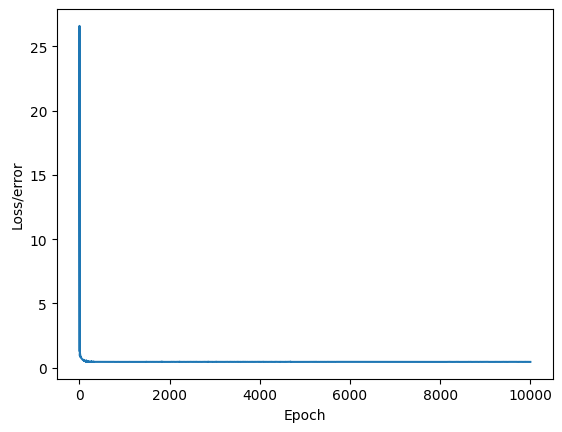

In [163]:
#lo graficamos 
plt.plot(range(epochs), losses)
plt.ylabel('Loss/error')
plt.xlabel('Epoch')

evaluamos el modelo en el set de prueba 

In [164]:
with torch.no_grad():
    #evaluamos el modelo en el set de prueba 
    y_eval = model.adelante(X_test)
    loss = criterion(y_eval, y_test)
    
    

In [165]:
loss

tensor(0.4390)

In [166]:
correctos = 0
with torch.no_grad():
    for i, data in enumerate(X_test):
        y_val = model.adelante(data)
        
        #nos va a decir la clase con mayor probabilidad
        print(f'{i+1}.) {str(y_val)  }\t \t  {y_test[i]}\t {y_val.argmax().item()}' )

        #averiguamos si es correcto o no
        if y_val.argmax().item() == y_test[i]:
            correctos += 1

print(f'El modelo tuvo {correctos} predicciones correctas de {len(y_test)} lo cual nos da un {(correctos/len(y_test))*100}% de efectividad')




1.) tensor([-6.5093,  0.9733,  3.8646])	 	  2	 2
2.) tensor([ 0.2004,  1.2459, -0.8797])	 	  1	 1
3.) tensor([-6.6833,  0.9662,  3.9877])	 	  2	 2
4.) tensor([-1.7594,  1.1663,  0.5061])	 	  1	 1
5.) tensor([-4.7960,  1.0429,  2.6532])	 	  2	 2
6.) tensor([-6.1619,  0.9874,  3.6190])	 	  2	 2
7.) tensor([-3.3575,  1.1013,  1.6361])	 	  2	 2
8.) tensor([-6.5155,  0.9730,  3.8690])	 	  2	 2
9.) tensor([ 0.8304,  1.1567, -1.2405])	 	  1	 1
10.) tensor([ 1.1508,  1.0384, -1.3702])	 	  0	 0
11.) tensor([-4.3852,  1.0596,  2.3627])	 	  2	 2
12.) tensor([ 0.9934,  1.0965, -1.3064])	 	  0	 1
13.) tensor([-0.4867,  1.2180, -0.3938])	 	  1	 1
14.) tensor([-11.3624,   0.7761,   7.2962])	 	  2	 2
15.) tensor([-2.3150,  1.1437,  0.8989])	 	  1	 1
16.) tensor([-5.7980,  1.0022,  3.3617])	 	  2	 2
17.) tensor([-5.9783,  0.9949,  3.4892])	 	  2	 2
18.) tensor([-6.1964,  0.9860,  3.6434])	 	  2	 2
19.) tensor([-2.2734,  1.1454,  0.8695])	 	  1	 1
20.) tensor([-2.8157,  1.1234,  1.2530])	 	  2	 2
21.) t